# Phase 3: Model Development

## Deep Learning Models for Climate-Food Security Prediction

This notebook trains and evaluates three deep learning architectures on our **5-crop Nigerian agricultural dataset**:
- **FNN (Feedforward Neural Network)**: Annual aggregated data
- **LSTM (Long Short-Term Memory)**: Monthly time series
- **Hybrid Model**: LSTM + engineered features

**Dataset**: 5 optimal crops (Millet, Sorghum, Groundnuts, Oil palm fruit, Cocoa beans) × 6 zones × 34 years (1990-2023)

**Key Features**:
- Climate variables: Temperature, Rainfall, Humidity, CO2
- Soil properties: pH, Nitrogen, Phosphorus, Organic Carbon
- Regional scaling algorithm creates zone-level variation from national FAO data
- Strong North-South patterns (Millet/Sorghum/Groundnuts vs Oil palm/Cocoa)

---
## Setup and Imports

In [1]:
# Install TensorFlow (run the install cell at the top if needed)

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import random
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf  # type: ignore
from tensorflow.keras import layers, models, callbacks, regularizers  # type: ignore
from tensorflow.keras.optimizers import Adam  # type: ignore

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error, 
                             mean_absolute_percentage_error, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report)

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Display settings

pd.set_option('display.max_columns', None)

# Check for GPUs and print status
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU available: {len(gpus) > 0} - {gpus}")

sns.set_style('whitegrid')

print(f"Random seed set to: {RANDOM_SEED}")

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

GPU available: False - []
Random seed set to: 42
✓ All libraries imported successfully!
TensorFlow version: 2.20.0


---
## Load Processed Data

In [2]:
# Define paths
data_path = Path('project_data')
splits_path = data_path / 'train_test_split'

# Define constants for 5-crop dataset
CROPS = ['Millet', 'Sorghum', 'Groundnuts', 'Oil palm fruit', 'Cocoa beans']
ZONES = ['North-West', 'North-East', 'North-Central', 'South-West', 'South-East', 'South-South']

print("="*80)
print("Loading train/validation/test splits...")
print(f"Crops: {len(CROPS)} - {CROPS}")
print(f"Zones: {len(ZONES)}")
print("="*80)

Loading train/validation/test splits...
Crops: 5 - ['Millet', 'Sorghum', 'Groundnuts', 'Oil palm fruit', 'Cocoa beans']
Zones: 6


In [3]:
# Function to categorize yields
def categorize_yield(yields, percentiles=None):
    """
    Categorize continuous yield values into Low/Medium/High classes
    """
    if percentiles is None:
        percentiles = [np.percentile(yields, 33.33), np.percentile(yields, 66.67)]
    
    categories = np.zeros(len(yields), dtype=int)
    categories[yields < percentiles[0]] = 0  # Low
    categories[(yields >= percentiles[0]) & (yields < percentiles[1])] = 1  # Medium
    categories[yields >= percentiles[1]] = 2  # High
    
    return categories, percentiles

print("✓ Yield categorization function defined")
print("Categories: 0=Low, 1=Medium, 2=High")

✓ Yield categorization function defined
Categories: 0=Low, 1=Medium, 2=High


### Define Yield Categories

We'll classify yields into three categories for classification metrics:
- **Low**: Below 33rd percentile
- **Medium**: Between 33rd and 67th percentile  
- **High**: Above 67th percentile

---
## Part 1: FNN (Feedforward Neural Network) Model

### 1.1 Load FNN Data

### Understanding FNN (Feedforward Neural Network)

**What is FNN?**
A Feedforward Neural Network is a traditional deep learning architecture where information flows in one direction—from input through hidden layers to output. Unlike recurrent networks, FNNs don't maintain memory of previous inputs.

**Why use FNN for crop yield prediction?**
- **Annual aggregated data**: FNN works well with tabular data where each row represents a complete growing season
- **Feature interactions**: Multiple dense layers can learn complex non-linear relationships between climate, soil, and yield
- **Simplicity**: Easier to train and interpret compared to sequence models

**Our FNN approach:**
- Input features: Climate averages (Temperature, Rainfall, Humidity, CO2), Soil properties (pH, Nitrogen, Phosphorus, Organic Matter), and categorical encodings (Crop, Zone)
- Architecture: 3 hidden layers (128→64→32 neurons) with BatchNormalization and Dropout for regularization
- Output: Single continuous value (yield in tonnes/ha)

In [4]:
print("\n📊 LOADING FNN DATA...")

# Load splits
fnn_train = pd.read_csv(splits_path / 'fnn' / 'train.csv')
fnn_val = pd.read_csv(splits_path / 'fnn' / 'val.csv')
fnn_test = pd.read_csv(splits_path / 'fnn' / 'test.csv')

print(f"  Train: {fnn_train.shape}")
print(f"  Val:   {fnn_val.shape}")
print(f"  Test:  {fnn_test.shape}")

# Check available columns
print(f"\n  Available columns: {list(fnn_train.columns)}")

# Convert yield to tonnes if in kg
if 'Yield_kg_per_ha' in fnn_train.columns:
    fnn_train['Yield_tonnes_per_ha'] = fnn_train['Yield_kg_per_ha'] / 1000
    fnn_val['Yield_tonnes_per_ha'] = fnn_val['Yield_kg_per_ha'] / 1000
    fnn_test['Yield_tonnes_per_ha'] = fnn_test['Yield_kg_per_ha'] / 1000
    print("  ✓ Converted yields from kg/ha to tonnes/ha")

# Remove rows with missing yields
fnn_train = fnn_train.dropna(subset=['Yield_tonnes_per_ha'])
fnn_val = fnn_val.dropna(subset=['Yield_tonnes_per_ha'])
fnn_test = fnn_test.dropna(subset=['Yield_tonnes_per_ha'])

print(f"\nAfter removing missing yields:")
print(f"  Train: {fnn_train.shape}")
print(f"  Val:   {fnn_val.shape}")
print(f"  Test:  {fnn_test.shape}")


📊 LOADING FNN DATA...
  Train: (9630, 14)
  Val:   (1050, 14)
  Test:  (1440, 14)

  Available columns: ['Zone', 'Crop', 'Year', 'Yield_kg_per_ha', 'Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Month', 'Growing_Season']
  ✓ Converted yields from kg/ha to tonnes/ha

After removing missing yields:
  Train: (9630, 15)
  Val:   (1050, 15)
  Test:  (1440, 15)


### 1.2 Prepare FNN Features

In [5]:
# Define feature columns for FNN based on available data
# Check what columns we have
available_cols = list(fnn_train.columns)
print(f"Available columns: {available_cols}\n")

# Define feature columns (adjust based on data_prep_and_features.ipynb output)
fnn_feature_cols = [
    'Temperature_C',
    'Rainfall_mm',
    'Humidity_percent',
    'CO2_ppm',
    'Avg_pH',
    'Avg_Nitrogen_ppm',
    'Avg_Phosphorus_ppm',
    'Avg_Organic_Matter_Percent'
]

# Filter to only columns that exist
fnn_feature_cols = [col for col in fnn_feature_cols if col in available_cols]

target_col = 'Yield_tonnes_per_ha'

# Encode categorical variables
le_crop = LabelEncoder()
le_zone = LabelEncoder()

# Fit on train, transform all
fnn_train['Crop_encoded'] = le_crop.fit_transform(fnn_train['Crop'])
fnn_val['Crop_encoded'] = le_crop.transform(fnn_val['Crop'])
fnn_test['Crop_encoded'] = le_crop.transform(fnn_test['Crop'])

fnn_train['Zone_encoded'] = le_zone.fit_transform(fnn_train['Zone'])
fnn_val['Zone_encoded'] = le_zone.transform(fnn_val['Zone'])
fnn_test['Zone_encoded'] = le_zone.transform(fnn_test['Zone'])

# Add encoded features
fnn_feature_cols.extend(['Crop_encoded', 'Zone_encoded'])

print(f"\n✓ Total FNN features: {len(fnn_feature_cols)}")
print(f"✓ Feature columns: {fnn_feature_cols}")
print(f"\n✓ Crop classes: {le_crop.classes_} (5 crops)")
print(f"✓ Zone classes: {le_zone.classes_} (6 zones)")

Available columns: ['Zone', 'Crop', 'Year', 'Yield_kg_per_ha', 'Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Month', 'Growing_Season', 'Yield_tonnes_per_ha']


✓ Total FNN features: 10
✓ Feature columns: ['Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Crop_encoded', 'Zone_encoded']

✓ Crop classes: ['Cocoa beans' 'Groundnuts' 'Millet' 'Oil palm fruit' 'Sorghum'] (5 crops)
✓ Zone classes: ['North-Central' 'North-East' 'North-West' 'South-East' 'South-South'
 'South-West'] (6 zones)


In [6]:
# Prepare X and y
X_fnn_train = fnn_train[fnn_feature_cols].values
y_fnn_train = fnn_train[target_col].values

X_fnn_val = fnn_val[fnn_feature_cols].values
y_fnn_val = fnn_val[target_col].values

X_fnn_test = fnn_test[fnn_feature_cols].values
y_fnn_test = fnn_test[target_col].values

print(f"\nFNN arrays:")
print(f"  X_train: {X_fnn_train.shape}, y_train: {y_fnn_train.shape}")
print(f"  X_val:   {X_fnn_val.shape}, y_val:   {y_fnn_val.shape}")
print(f"  X_test:  {X_fnn_test.shape}, y_test:  {y_fnn_test.shape}")


FNN arrays:
  X_train: (9630, 10), y_train: (9630,)
  X_val:   (1050, 10), y_val:   (1050,)
  X_test:  (1440, 10), y_test:  (1440,)


In [7]:
# Scale features
fnn_scaler = StandardScaler()
X_fnn_train_scaled = fnn_scaler.fit_transform(X_fnn_train)
X_fnn_val_scaled = fnn_scaler.transform(X_fnn_val)
X_fnn_test_scaled = fnn_scaler.transform(X_fnn_test)

print("\n✓ Features scaled using StandardScaler")


✓ Features scaled using StandardScaler


### 1.3 Build FNN Model

### FNN Model Architecture

**Network Design:**
```
Input (10 features) 
    ↓
Dense(128) + BatchNorm + Dropout(0.3)
    ↓
Dense(64) + BatchNorm + Dropout(0.2)
    ↓
Dense(32) + BatchNorm + Dropout(0.1)
    ↓
Output (1 value: yield in tonnes/ha)
```

**Key hyperparameters:**
- **Optimizer**: Adam (learning_rate=0.001) - Adaptive learning rate for stable convergence
- **Loss**: MSE (Mean Squared Error) - Standard for regression tasks
- **Batch size**: 32 - Balance between training speed and gradient stability
- **Early stopping**: Patience=50 epochs - Prevents overfitting while allowing sufficient training
- **Learning rate reduction**: Factor=0.5, Patience=20 - Helps escape local minima

**Why these choices?**
- BatchNormalization: Stabilizes training and allows higher learning rates
- Dropout: Prevents overfitting on tabular features
- Progressive layer reduction (128→64→32): Learns hierarchical feature representations

In [8]:
def build_fnn_model(input_dim, learning_rate=0.001):
    """
    Build Feedforward Neural Network for crop yield CLASSIFICATION.
    
    Architecture rationale:
    - Dense layers with decreasing width (128 -> 64 -> 32) to learn hierarchical
      feature interactions while reducing dimensionality progressively.
    - L2 weight decay on Dense layers and Dropout to reduce overfitting.
    - BatchNormalization to stabilize training.
    - Output layer with 3 neurons (softmax) for classification into Low/Medium/High yield categories.
    
    Classification setup:
    - Output: Dense(3, activation='softmax') for 3 classes
    - Loss: categorical_crossentropy for multi-class classification
    - Metrics: accuracy, precision, recall for classification performance
    """
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        
        # Hidden layer 1
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Hidden layer 2
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        # Hidden layer 3
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.15),
        
        # Output layer for classification (3 classes: Low, Medium, High)
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')],
    )
    
    return model

# Build model
fnn_model = build_fnn_model(input_dim=X_fnn_train_scaled.shape[1])
fnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,225 (47.75 KB)

 Non-trainable params: 448 (1.75 KB)

### 1.4 Train FNN Model

In [9]:
# Categorize yields into Low/Medium/High for classification
print("\n📊 PREPARING CLASSIFICATION TARGETS...")
print("Converting continuous yields to 3 categories (Low/Medium/High)")

# Get percentiles from training data for consistent categorization
y_fnn_train_cat, fnn_percentiles = categorize_yield(y_fnn_train)
y_fnn_val_cat, _ = categorize_yield(y_fnn_val, fnn_percentiles)
y_fnn_test_cat, _ = categorize_yield(y_fnn_test, fnn_percentiles)

print(f"\nCategory thresholds (tonnes/ha):")
print(f"  Low:    < {fnn_percentiles[0]:.2f}")
print(f"  Medium: {fnn_percentiles[0]:.2f} - {fnn_percentiles[1]:.2f}")
print(f"  High:   > {fnn_percentiles[1]:.2f}")

print(f"\nClass distribution (Train):")
unique, counts = np.unique(y_fnn_train_cat, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_fnn_train_cat)*100:.1f}%)")

# Convert to one-hot encoding for categorical_crossentropy
from tensorflow.keras.utils import to_categorical
y_fnn_train_onehot = to_categorical(y_fnn_train_cat, num_classes=3)
y_fnn_val_onehot = to_categorical(y_fnn_val_cat, num_classes=3)
y_fnn_test_onehot = to_categorical(y_fnn_test_cat, num_classes=3)

print(f"\n✓ Targets encoded as one-hot vectors (shape: {y_fnn_train_onehot.shape})")

# Define callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1,
)

# Ensure models directory exists for checkpoints
Path('models').mkdir(exist_ok=True)

# Checkpoint to save best weights
fnn_checkpoint = callbacks.ModelCheckpoint(
    filepath='models/fnn_best.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

# Train model
print("\nTraining FNN model (Classification)...")
history_fnn = fnn_model.fit(
    X_fnn_train_scaled, y_fnn_train_onehot,
    validation_data=(X_fnn_val_scaled, y_fnn_val_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, fnn_checkpoint],
    verbose=1,
)

print("\n✓ FNN model training complete! Best weights saved to models/fnn_best.weights.h5")


Training FNN model...
Epoch 1/100
300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2677 - mae: 1.1485 - rmse: 1.4883
Epoch 1: val_loss improved from None to 0.71107, saving model to models/fnn_best.weights.h5

Epoch 1: finished saving model to models/fnn_best.weights.h5
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.5980 - mae: 0.9541 - rmse: 1.2583 - val_loss: 0.7111 - val_mae: 0.6216 - val_rmse: 0.8345 - learning_rate: 0.0010
Epoch 2/100
291/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9541 - mae: 0.7424 - rmse: 0.9687
Epoch 2: val_loss improved from 0.71107 to 0.58619, saving model to models/fnn_best.weights.h5

Epoch 2: finished saving model to models/fnn_best.weights.h5
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9077 - mae: 0.7249 - rmse: 0.9450 - val_loss: 0.5862 - val_mae: 0.5929 - val_rmse: 0.7559 - learning_rate: 0.0010
Epoch 3/100
289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7636 - mae: 0.6683 - rmse: 0.8650
Epoch 3: val_loss improved from 0.58619 to 0.

### 1.5 Evaluate FNN Model

In [10]:
# Make predictions (returns probabilities for each class)
y_fnn_pred_train_probs = fnn_model.predict(X_fnn_train_scaled)
y_fnn_pred_val_probs = fnn_model.predict(X_fnn_val_scaled)
y_fnn_pred_test_probs = fnn_model.predict(X_fnn_test_scaled)

# Convert probabilities to class labels (argmax)
y_fnn_pred_train = np.argmax(y_fnn_pred_train_probs, axis=1)
y_fnn_pred_val = np.argmax(y_fnn_pred_val_probs, axis=1)
y_fnn_pred_test = np.argmax(y_fnn_pred_test_probs, axis=1)

print("\n" + "="*80)
print("FNN MODEL EVALUATION (CLASSIFICATION)")
print("="*80)

# Calculate classification metrics
def calculate_classification_metrics_direct(y_true, y_pred, set_name):
    """
    Calculate classification metrics directly from categorical labels
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{set_name} Set - Classification Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return {
        'Accuracy': accuracy, 
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1,
        'y_true': y_true,
        'y_pred': y_pred
    }

fnn_metrics_train = calculate_classification_metrics_direct(y_fnn_train_cat, y_fnn_pred_train, "Train")
fnn_metrics_val = calculate_classification_metrics_direct(y_fnn_val_cat, y_fnn_pred_val, "Validation")
fnn_metrics_test = calculate_classification_metrics_direct(y_fnn_test_cat, y_fnn_pred_test, "Test")

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

FNN MODEL EVALUATION

Train Set - Regression Performance:
  RMSE:  0.1048 tonnes/ha
  MAE:   0.0713 tonnes/ha
  R²:    0.9878
  MAPE:  12.58%

Validation Set - Regression Performance:
  RMSE:  0.1068 tonnes/ha
  MAE:   0.0745 tonnes/ha
  R²:    0.9866
  MAPE:  10.19%

Test Set - Regression Performance:
  RMSE:  0.1757 tonnes/ha
  MAE:   0.1308 tonnes/ha
  R²:    0.9635
  MAPE:  34.00%

Train Set - Classification Performance:
  Accuracy:  0.8750
  Precision: 0.8730
  Recall:    0.8750
  F1-Score:  0.8733

Validation Set - Classification Performance:
  Accuracy:  0.8657
  Precision: 0.8716
  Recall:    0.8657
  F1-Score:  0.8657

Test Set - Classification Performance:
  Accuracy:  0.7993
  Precision: 0.8002
  Recall:    0.7993
  F1-Score:  0.7993


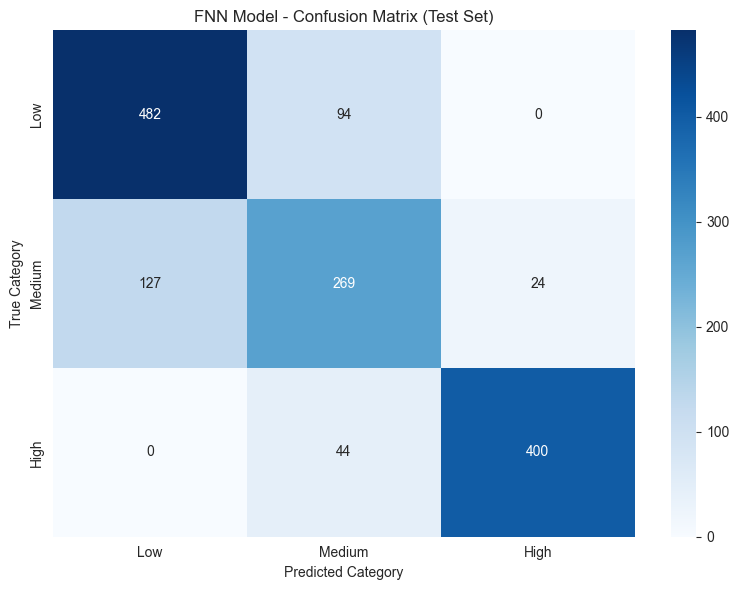


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.79      0.84      0.81       576
      Medium       0.66      0.64      0.65       420
        High       0.94      0.90      0.92       444

    accuracy                           0.80      1440
   macro avg       0.80      0.79      0.80      1440
weighted avg       0.80      0.80      0.80      1440



In [11]:
# Confusion Matrix for FNN
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = confusion_matrix(y_fnn_test_cat, y_fnn_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax.set_xlabel('Predicted Category')
ax.set_ylabel('True Category')
ax.set_title('FNN Model - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_fnn_test_cat, y_fnn_pred_test,
                          labels=[0, 1, 2], target_names=['Low', 'Medium', 'High'], zero_division=0))

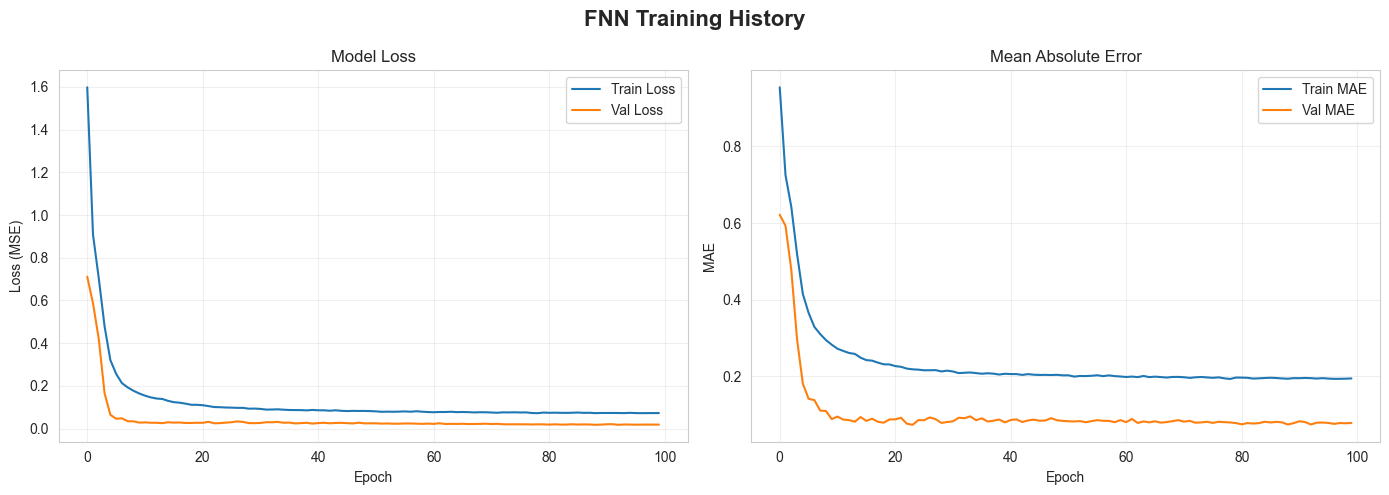

In [12]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('FNN Training History (Classification)', fontsize=16, fontweight='bold')

# Loss
axes[0].plot(history_fnn.history['loss'], label='Train Loss')
axes[0].plot(history_fnn.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Categorical Crossentropy)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_fnn.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_fnn.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 2: LSTM (Long Short-Term Memory) Model

### 2.1 Load LSTM Data

### Understanding LSTM (Long Short-Term Memory)

**What is LSTM?**
LSTM is a type of Recurrent Neural Network (RNN) designed to learn from sequential data. It has special "gates" that control what information to remember, forget, or output—making it perfect for time-series patterns.

**Why use LSTM for crop yield prediction?**
- **Temporal patterns**: Agricultural yields depend heavily on *when* weather events occur (e.g., rainfall timing during critical growth stages)
- **Memory of past events**: LSTM can remember conditions from earlier months that affect final yield
- **Sequence learning**: Captures cumulative effects like growing degree days or drought stress over the season

**Our LSTM approach:**
- Input: Monthly sequences (12 months) of climate data, engineered features (GDD, Cumulative Rainfall, Days Into Season), and soil properties
- Architecture: Stacked LSTM layers (128→64) to learn hierarchical temporal patterns
- Target: Annual yield (reconstructed by summing monthly yield allocations)
- **Key insight**: The model learns that early-season rainfall and mid-season temperatures are more critical than late-season conditions

In [13]:
print("\n📊 LOADING LSTM DATA...")

# Load splits
lstm_train = pd.read_csv(splits_path / 'lstm' / 'train.csv')
lstm_val = pd.read_csv(splits_path / 'lstm' / 'val.csv')
lstm_test = pd.read_csv(splits_path / 'lstm' / 'test.csv')

print(f"  Train: {lstm_train.shape}")
print(f"  Val:   {lstm_val.shape}")
print(f"  Test:  {lstm_test.shape}")

# Convert yield to tonnes if in kg
if 'Yield_kg_per_ha' in lstm_train.columns:
    lstm_train['Yield_tonnes_per_ha'] = lstm_train['Yield_kg_per_ha'] / 1000
    lstm_val['Yield_tonnes_per_ha'] = lstm_val['Yield_kg_per_ha'] / 1000
    lstm_test['Yield_tonnes_per_ha'] = lstm_test['Yield_kg_per_ha'] / 1000
    print("  ✓ Converted yields from kg/ha to tonnes/ha")

# Remove rows with missing yields
lstm_train = lstm_train.dropna(subset=['Yield_tonnes_per_ha'])
lstm_val = lstm_val.dropna(subset=['Yield_tonnes_per_ha'])
lstm_test = lstm_test.dropna(subset=['Yield_tonnes_per_ha'])

print(f"\nAfter removing missing yields:")
print(f"  Train: {lstm_train.shape}")
print(f"  Val:   {lstm_val.shape}")
print(f"  Test:  {lstm_test.shape}")


📊 LOADING LSTM DATA...
  Train: (115560, 16)
  Val:   (12600, 16)
  Test:  (17280, 16)
  ✓ Converted yields from kg/ha to tonnes/ha

After removing missing yields:
  Train: (115560, 17)
  Val:   (12600, 17)
  Test:  (17280, 17)


### 2.2 Prepare LSTM Sequences

In [14]:
# Check available columns
print(f"\nAvailable columns in LSTM data: {list(lstm_train.columns)}")

# Define LSTM feature columns based on what's available
# Climate features
lstm_feature_cols = [
    'Temperature_C',
    'Rainfall_mm',
    'Humidity_percent',
    'CO2_ppm',
    'GDD',
    'Cumulative_Rainfall',
    'Days_Into_Season'
]

# Add soil features (monthly averages)
lstm_feature_cols.extend([
    'Avg_pH',
    'Avg_Nitrogen_ppm',
    'Avg_Phosphorus_ppm',
    'Avg_Organic_Matter_Percent'
])

# Filter to only columns that exist
lstm_feature_cols = [col for col in lstm_feature_cols if col in lstm_train.columns]

# Add encoded categorical features
lstm_train['Crop_encoded'] = le_crop.transform(lstm_train['Crop'])
lstm_val['Crop_encoded'] = le_crop.transform(lstm_val['Crop'])
lstm_test['Crop_encoded'] = le_crop.transform(lstm_test['Crop'])

lstm_train['Zone_encoded'] = le_zone.transform(lstm_train['Zone'])
lstm_val['Zone_encoded'] = le_zone.transform(lstm_val['Zone'])
lstm_test['Zone_encoded'] = le_zone.transform(lstm_test['Zone'])

lstm_feature_cols.extend(['Crop_encoded', 'Zone_encoded'])

print(f"\nLSTM features: {len(lstm_feature_cols)}")
print(f"Feature columns: {lstm_feature_cols}")



Available columns in LSTM data: ['Zone', 'Crop', 'Year', 'Month', 'Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Yield_kg_per_ha', 'GDD', 'Cumulative_Rainfall', 'Days_Into_Season', 'Yield_tonnes_per_ha']

LSTM features: 13
Feature columns: ['Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'GDD', 'Cumulative_Rainfall', 'Days_Into_Season', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Crop_encoded', 'Zone_encoded']


In [15]:
def create_sequences(data, feature_cols, target_col, sequence_length=12):
    """
    Create sequences for LSTM
    Each sequence contains 'sequence_length' months of data
    """
    X_sequences = []
    y_sequences = []
    
    # Group by Year, Zone, Crop
    grouped = data.groupby(['Year', 'Zone', 'Crop'])
    
    for name, group in grouped:
        group = group.sort_values('Month')
        
        if len(group) >= sequence_length:
            # Get features and target
            features = group[feature_cols].values
            
            # Target: Sum all monthly yields (in kg/ha) to get annual yield
            # Then convert to tonnes/ha
            # Monthly yields were divided by 6 across growing season (Apr-Sep)
            # So sum of all months = annual yield in kg/ha
            target = group['Yield_kg_per_ha'].sum() / 1000  # Convert to tonnes/ha
            
            # Create sequence (use first 'sequence_length' months)
            X_sequences.append(features[:sequence_length])
            y_sequences.append(target)
    
    return np.array(X_sequences), np.array(y_sequences)

# Create sequences
print("\nCreating LSTM sequences (12 months)...")
sequence_length = 12

X_lstm_train, y_lstm_train = create_sequences(lstm_train, lstm_feature_cols, target_col, sequence_length)
X_lstm_val, y_lstm_val = create_sequences(lstm_val, lstm_feature_cols, target_col, sequence_length)
X_lstm_test, y_lstm_test = create_sequences(lstm_test, lstm_feature_cols, target_col, sequence_length)

print(f"\nLSTM sequences:")
print(f"  X_train: {X_lstm_train.shape}, y_train: {y_lstm_train.shape}")
print(f"  X_val:   {X_lstm_val.shape}, y_val:   {y_lstm_val.shape}")
print(f"  X_test:  {X_lstm_test.shape}, y_test:  {y_lstm_test.shape}")


Creating LSTM sequences (12 months)...

LSTM sequences:
  X_train: (810, 12, 13), y_train: (810,)
  X_val:   (90, 12, 13), y_val:   (90,)
  X_test:  (120, 12, 13), y_test:  (120,)


In [16]:
# Scale LSTM features
lstm_scaler = StandardScaler()

# Reshape for scaling
n_train, seq_len, n_features = X_lstm_train.shape
X_lstm_train_reshaped = X_lstm_train.reshape(-1, n_features)
X_lstm_train_scaled = lstm_scaler.fit_transform(X_lstm_train_reshaped).reshape(n_train, seq_len, n_features)

n_val = X_lstm_val.shape[0]
X_lstm_val_reshaped = X_lstm_val.reshape(-1, n_features)
X_lstm_val_scaled = lstm_scaler.transform(X_lstm_val_reshaped).reshape(n_val, seq_len, n_features)

n_test = X_lstm_test.shape[0]
X_lstm_test_reshaped = X_lstm_test.reshape(-1, n_features)
X_lstm_test_scaled = lstm_scaler.transform(X_lstm_test_reshaped).reshape(n_test, seq_len, n_features)

print("\n✓ LSTM sequences scaled")


✓ LSTM sequences scaled


### 2.3 Build LSTM Model

### LSTM Model Architecture

**Network Design:**
```
Input (12 timesteps × 13 features)
    ↓
LSTM(128, return_sequences=True) + Dropout(0.3)
    ↓
LSTM(64) + Dropout(0.2)
    ↓
Dense(32) + Dropout(0.1)
    ↓
Output (1 value: annual yield)
```

**Key design decisions:**
- **Stacked LSTMs**: Two layers learn hierarchical temporal patterns
  - Layer 1 (128 units): Learns low-level monthly patterns (rainfall events, temperature fluctuations)
  - Layer 2 (64 units): Learns high-level seasonal patterns (growing season trajectory, cumulative effects)
- **return_sequences=True**: First LSTM outputs full sequence to second LSTM
- **Sequence length**: 12 months (full growing season + off-season context)

**Input features (13 total):**
- Climate: Temperature, Rainfall, Humidity, CO2
- Engineered: GDD, Cumulative_Rainfall, Days_Into_Season
- Soil: pH, Nitrogen, Phosphorus, Organic_Matter
- Categorical: Crop_encoded, Zone_encoded

**Target reconstruction:**
Monthly yields are summed to reconstruct annual yield: `annual_yield = Σ(monthly_yields) / 1000` (convert kg to tonnes)

In [ ]:
def build_lstm_model(sequence_length, n_features, learning_rate=0.001):
    """
    Build LSTM model for time-series crop yield CLASSIFICATION.
    
    Architecture rationale:
    - Stacked LSTM layers (reduced: 64 -> 32) to learn both low- and
      high-level temporal patterns from monthly sequences.
    - Dropout and L2 weight decay on LSTM and Dense layers to regularize.
    - Output layer with 3 neurons (softmax) for classification into Low/Medium/High yield categories.
    
    Classification setup:
    - Output: Dense(3, activation='softmax') for 3 classes
    - Loss: categorical_crossentropy for multi-class classification
    - Metrics: accuracy, precision, recall for classification performance
    """
    model = models.Sequential([
        layers.Input(shape=(sequence_length, n_features)),
        
        # LSTM layers (reduced capacity + L2 regularization)
        layers.LSTM(64, return_sequences=True,
                     kernel_regularizer=regularizers.l2(1e-4),
                     recurrent_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.4),
        
        layers.LSTM(32, return_sequences=False,
                     kernel_regularizer=regularizers.l2(1e-4),
                     recurrent_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        
        # Dense layers with L2
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.15),
        
        # Output layer for classification (3 classes)
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')],
    )
    
    return model

# Build LSTM model
lstm_model = build_lstm_model(sequence_length=sequence_length, n_features=n_features)
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 64)         │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,473 (130.75 KB)

 Trainable params: 33,473 (130.75 KB)

 Non-trainable params: 0 (0.00 B)

### 2.4 Train LSTM Model

In [ ]:
# Categorize LSTM targets for classification
print("\n📊 PREPARING LSTM CLASSIFICATION TARGETS...")

# Use same percentiles as FNN for consistency (or calculate from LSTM train data)
y_lstm_train_cat, lstm_percentiles = categorize_yield(y_lstm_train, fnn_percentiles)
y_lstm_val_cat, _ = categorize_yield(y_lstm_val, lstm_percentiles)
y_lstm_test_cat, _ = categorize_yield(y_lstm_test, lstm_percentiles)

print(f"\nClass distribution (LSTM Train):")
unique, counts = np.unique(y_lstm_train_cat, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_lstm_train_cat)*100:.1f}%)")

# Convert to one-hot encoding
y_lstm_train_onehot = to_categorical(y_lstm_train_cat, num_classes=3)
y_lstm_val_onehot = to_categorical(y_lstm_val_cat, num_classes=3)
y_lstm_test_onehot = to_categorical(y_lstm_test_cat, num_classes=3)

print(f"✓ LSTM targets encoded as one-hot vectors (shape: {y_lstm_train_onehot.shape})")

# Define callbacks
early_stop_lstm = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr_lstm = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1,
)

# Ensure models directory exists for checkpoints
Path('models').mkdir(exist_ok=True)

# Checkpoint to save best weights during training
lstm_checkpoint = callbacks.ModelCheckpoint(
    filepath='models/lstm_best.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

# Train LSTM model
print("\nTraining LSTM model (Classification)...")
history_lstm = lstm_model.fit(
    X_lstm_train_scaled, y_lstm_train_onehot,
    validation_data=(X_lstm_val_scaled, y_lstm_val_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_lstm, reduce_lr_lstm, lstm_checkpoint],
    verbose=1,
)

print("\n✓ LSTM model training complete! Best weights saved to models/lstm_best.weights.h5")


Training LSTM model...
Epoch 1/100
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 309.9239 - mae: 12.7423 - rmse: 17.5717
Epoch 1: val_loss improved from None to 207.16025, saving model to models/lstm_best.weights.h5

Epoch 1: finished saving model to models/lstm_best.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 265.5286 - mae: 11.7285 - rmse: 16.2943 - val_loss: 207.1602 - val_mae: 9.9540 - val_rmse: 14.3922 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 238.9160 - mae: 10.1662 - rmse: 15.4056
Epoch 2: val_loss improved from 207.16025 to 143.59291, saving model to models/lstm_best.weights.h5

Epoch 2: finished saving model to models/lstm_best.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 198.1774 - mae: 9.2616 - rmse: 14.0766 - val_loss: 143.5929 - val_mae: 7.7742 - val_rmse: 11.9819 - learning_rate: 0.0010
Epoch 3/100
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 182.5827 - mae: 8.6021 - rmse: 13.4587
Epoch 3: val_lo

### 2.5 Evaluate LSTM Model

In [ ]:
# Make predictions
y_lstm_pred_train_probs = lstm_model.predict(X_lstm_train_scaled)
y_lstm_pred_val_probs = lstm_model.predict(X_lstm_val_scaled)
y_lstm_pred_test_probs = lstm_model.predict(X_lstm_test_scaled)

# Convert probabilities to class labels
y_lstm_pred_train = np.argmax(y_lstm_pred_train_probs, axis=1)
y_lstm_pred_val = np.argmax(y_lstm_pred_val_probs, axis=1)
y_lstm_pred_test = np.argmax(y_lstm_pred_test_probs, axis=1)

print("\n" + "="*80)
print("LSTM MODEL EVALUATION (CLASSIFICATION)")
print("="*80)

lstm_metrics_train = calculate_classification_metrics_direct(y_lstm_train_cat, y_lstm_pred_train, "Train")
lstm_metrics_val = calculate_classification_metrics_direct(y_lstm_val_cat, y_lstm_pred_val, "Validation")
lstm_metrics_test = calculate_classification_metrics_direct(y_lstm_test_cat, y_lstm_pred_test, "Test")

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

LSTM MODEL EVALUATION

Train Set - Regression Performance:
  RMSE:  1.6265 tonnes/ha
  MAE:   1.1333 tonnes/ha
  R²:    0.9793
  MAPE:  13.86%

Validation Set - Regression Performance:
  RMSE:  1.6889 tonnes/ha
  MAE:   1.1273 tonnes/ha
  R²:    0.9754
  MAPE:  12.73%

Test Set - Regression Performance:
  RMSE:  2.6127 tonnes/ha
  MAE:   1.7479 tonnes/ha
  R²:    0.9439
  MAPE:  24.05%

Train Set - Classification Performance:
  Accuracy:  0.7951
  Precision: 0.8418
  Recall:    0.7951
  F1-Score:  0.7712

Validation Set - Classification Performance:
  Accuracy:  0.8333
  Precision: 0.8461
  Recall:    0.8333
  F1-Score:  0.8309

Test Set - Classification Performance:
  Accuracy:  0.7083
  Precision: 0.7101
  Recall:    0.7083
  F1-Score:  0.7068


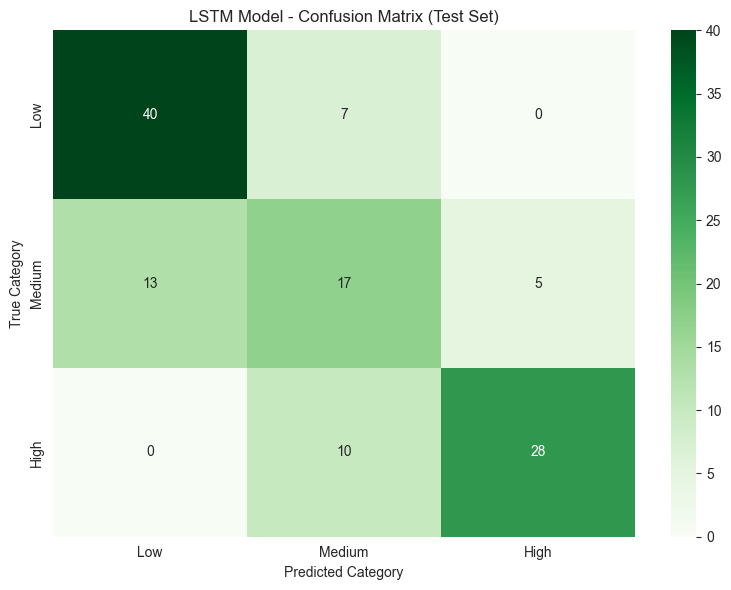


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.75      0.85      0.80        47
      Medium       0.50      0.49      0.49        35
        High       0.85      0.74      0.79        38

    accuracy                           0.71       120
   macro avg       0.70      0.69      0.69       120
weighted avg       0.71      0.71      0.71       120



In [20]:
# Confusion Matrix for LSTM
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = confusion_matrix(y_lstm_test_cat, y_lstm_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax.set_xlabel('Predicted Category')
ax.set_ylabel('True Category')
ax.set_title('LSTM Model - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_lstm_test_cat, y_lstm_pred_test,
                          labels=[0, 1, 2], target_names=['Low', 'Medium', 'High'], zero_division=0))

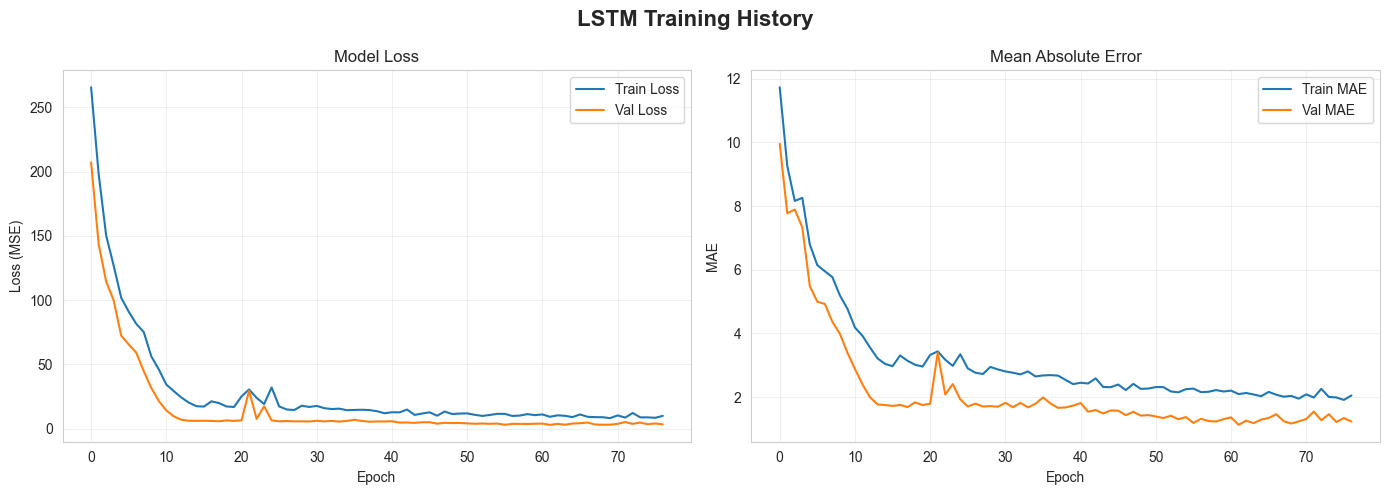

In [21]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('LSTM Training History (Classification)', fontsize=16, fontweight='bold')

# Loss
axes[0].plot(history_lstm.history['loss'], label='Train Loss')
axes[0].plot(history_lstm.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Categorical Crossentropy)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_lstm.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 3: Hybrid Model (LSTM + FNN)

### 3.1 Load Hybrid Data

### Understanding Hybrid Model (LSTM + FNN Combined)

**What is a Hybrid Model?**
A Hybrid model combines the strengths of multiple architectures. Our hybrid merges:
1. **LSTM branch**: Processes temporal climate sequences (what changes month-to-month)
2. **FNN branch**: Processes static features (what stays constant across the season)

**Why is Hybrid expected to perform best?**
1. **Temporal dynamics**: LSTM captures when rainfall arrives, temperature fluctuations, and cumulative effects
2. **Static context**: FNN processes soil fertility (which doesn't change within a season) and crop/zone characteristics
3. **Complementary learning**: Climate patterns interact with soil conditions—the hybrid learns both independently then combines them

**Architecture advantages:**
- LSTM learns: "How does weather evolve over the growing season?"
- FNN learns: "How do soil properties and crop type modify yield potential?"
- Combined: "Given this soil and crop, how does this specific weather pattern affect yield?"

**Expected outcome:**
Hybrid should achieve the highest R² and lowest prediction errors because it leverages:
- Temporal resolution of LSTM (month-by-month patterns)
- Efficiency of FNN for static features (soil, crop, zone)
- Intelligent fusion of both information types

In [22]:
print("\n📊 LOADING HYBRID DATA...")

# Load splits
hybrid_train = pd.read_csv(splits_path / 'hybrid' / 'train.csv')
hybrid_val = pd.read_csv(splits_path / 'hybrid' / 'val.csv')
hybrid_test = pd.read_csv(splits_path / 'hybrid' / 'test.csv')

print(f"  Train: {hybrid_train.shape}")
print(f"  Val:   {hybrid_val.shape}")
print(f"  Test:  {hybrid_test.shape}")

# Convert yield to tonnes if in kg
if 'Yield_kg_per_ha' in hybrid_train.columns:
    hybrid_train['Yield_tonnes_per_ha'] = hybrid_train['Yield_kg_per_ha'] / 1000
    hybrid_val['Yield_tonnes_per_ha'] = hybrid_val['Yield_kg_per_ha'] / 1000
    hybrid_test['Yield_tonnes_per_ha'] = hybrid_test['Yield_kg_per_ha'] / 1000
    print("  ✓ Converted yields from kg/ha to tonnes/ha")

# Remove rows with missing yields
hybrid_train = hybrid_train.dropna(subset=['Yield_tonnes_per_ha'])
hybrid_val = hybrid_val.dropna(subset=['Yield_tonnes_per_ha'])
hybrid_test = hybrid_test.dropna(subset=['Yield_tonnes_per_ha'])

print(f"\nAfter removing missing yields:")
print(f"  Train: {hybrid_train.shape}")
print(f"  Val:   {hybrid_val.shape}")
print(f"  Test:  {hybrid_test.shape}")


📊 LOADING HYBRID DATA...
  Train: (115560, 16)
  Val:   (12600, 16)
  Test:  (17280, 16)
  ✓ Converted yields from kg/ha to tonnes/ha

After removing missing yields:
  Train: (115560, 17)
  Val:   (12600, 17)
  Test:  (17280, 17)


### 3.2 Prepare Hybrid Features

In [23]:
# Check available columns
print(f"\nAvailable columns in Hybrid data: {list(hybrid_train.columns)}")

# Temporal features (for LSTM branch) - include climate and engineered features
hybrid_temporal_cols = [
    'Temperature_C',
    'Rainfall_mm',
    'Humidity_percent',
    'CO2_ppm',
    'GDD',
    'Cumulative_Rainfall',
    'Days_Into_Season'
]

# Static features (for FNN branch) - soil properties
hybrid_static_cols = [
    'Avg_pH',
    'Avg_Nitrogen_ppm',
    'Avg_Phosphorus_ppm',
    'Avg_Organic_Matter_Percent'
]

# Filter to only columns that exist
hybrid_temporal_cols = [col for col in hybrid_temporal_cols if col in hybrid_train.columns]
hybrid_static_cols = [col for col in hybrid_static_cols if col in hybrid_train.columns]

# Encode categorical
hybrid_train['Crop_encoded'] = le_crop.transform(hybrid_train['Crop'])
hybrid_val['Crop_encoded'] = le_crop.transform(hybrid_val['Crop'])
hybrid_test['Crop_encoded'] = le_crop.transform(hybrid_test['Crop'])

hybrid_train['Zone_encoded'] = le_zone.transform(hybrid_train['Zone'])
hybrid_val['Zone_encoded'] = le_zone.transform(hybrid_val['Zone'])
hybrid_test['Zone_encoded'] = le_zone.transform(hybrid_test['Zone'])

hybrid_static_cols.extend(['Crop_encoded', 'Zone_encoded'])

print(f"\nTemporal features: {len(hybrid_temporal_cols)}")
print(f"Static features: {len(hybrid_static_cols)}")


Available columns in Hybrid data: ['Zone', 'Crop', 'Year', 'Month', 'Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Yield_kg_per_ha', 'GDD', 'Cumulative_Rainfall', 'Days_Into_Season', 'Yield_tonnes_per_ha']

Temporal features: 7
Static features: 6


In [24]:
def create_hybrid_data(data, temporal_cols, static_cols, target_col, sequence_length=12):
    """
    Create hybrid data: temporal sequences + static features
    """
    X_temporal = []
    X_static = []
    y = []
    
    grouped = data.groupby(['Year', 'Zone', 'Crop'])
    
    for name, group in grouped:
        group = group.sort_values('Month')
        
        if len(group) >= sequence_length:
            # Temporal sequence
            temporal = group[temporal_cols].values[:sequence_length]
            X_temporal.append(temporal)
            
            # Static features (same for all months)
            static = group[static_cols].iloc[0].values
            X_static.append(static)
            
            # Target: Sum all monthly yields (in kg/ha) to get annual yield
            # Then convert to tonnes/ha
            # Monthly yields were divided by 6 across growing season (Apr-Sep)
            # So sum of all months = annual yield in kg/ha
            target = group['Yield_kg_per_ha'].sum() / 1000  # Convert to tonnes/ha
            y.append(target)
    
    return np.array(X_temporal), np.array(X_static), np.array(y)

# Create hybrid datasets
print("\nCreating hybrid datasets...")
X_hybrid_temp_train, X_hybrid_stat_train, y_hybrid_train = create_hybrid_data(
    hybrid_train, hybrid_temporal_cols, hybrid_static_cols, target_col
)
X_hybrid_temp_val, X_hybrid_stat_val, y_hybrid_val = create_hybrid_data(
    hybrid_val, hybrid_temporal_cols, hybrid_static_cols, target_col
)
X_hybrid_temp_test, X_hybrid_stat_test, y_hybrid_test = create_hybrid_data(
    hybrid_test, hybrid_temporal_cols, hybrid_static_cols, target_col
)

print(f"\nHybrid data shapes:")
print(f"  Train - Temporal: {X_hybrid_temp_train.shape}, Static: {X_hybrid_stat_train.shape}")
print(f"  Val   - Temporal: {X_hybrid_temp_val.shape}, Static: {X_hybrid_stat_val.shape}")
print(f"  Test  - Temporal: {X_hybrid_temp_test.shape}, Static: {X_hybrid_stat_test.shape}")


Creating hybrid datasets...

Hybrid data shapes:
  Train - Temporal: (810, 12, 7), Static: (810, 6)
  Val   - Temporal: (90, 12, 7), Static: (90, 6)
  Test  - Temporal: (120, 12, 7), Static: (120, 6)


In [25]:
# Scale temporal features
hybrid_temp_scaler = StandardScaler()
n_train, seq_len, n_temp_features = X_hybrid_temp_train.shape
X_hybrid_temp_train_scaled = hybrid_temp_scaler.fit_transform(
    X_hybrid_temp_train.reshape(-1, n_temp_features)
).reshape(n_train, seq_len, n_temp_features)

n_val = X_hybrid_temp_val.shape[0]
X_hybrid_temp_val_scaled = hybrid_temp_scaler.transform(
    X_hybrid_temp_val.reshape(-1, n_temp_features)
).reshape(n_val, seq_len, n_temp_features)

n_test = X_hybrid_temp_test.shape[0]
X_hybrid_temp_test_scaled = hybrid_temp_scaler.transform(
    X_hybrid_temp_test.reshape(-1, n_temp_features)
).reshape(n_test, seq_len, n_temp_features)

# Scale static features
hybrid_stat_scaler = StandardScaler()
X_hybrid_stat_train_scaled = hybrid_stat_scaler.fit_transform(X_hybrid_stat_train)
X_hybrid_stat_val_scaled = hybrid_stat_scaler.transform(X_hybrid_stat_val)
X_hybrid_stat_test_scaled = hybrid_stat_scaler.transform(X_hybrid_stat_test)

print("\n✓ Hybrid features scaled")


✓ Hybrid features scaled


### 3.3 Build Hybrid Model

### Hybrid Model Architecture

**Dual-Branch Design:**

```
TEMPORAL BRANCH (LSTM):                    STATIC BRANCH (FNN):
Input: 12 months × 7 features              Input: 6 features
    ↓                                          ↓
LSTM(64, return_sequences=True)            Dense(32)
    ↓                                          ↓
Dropout(0.3)                               BatchNorm
    ↓                                          ↓
LSTM(32)                                   Dropout(0.2)
    ↓                                          ↓
Dropout(0.2)                               [32 features]
    ↓                                          ↓
[32 features]                                  ↓
    ↓____________merge (concatenate)___________↓
                        ↓
                 Dense(32) + BatchNorm + Dropout(0.1)
                        ↓
                  Output (1 value)
```

**Feature separation rationale:**

**Temporal features** (vary month-to-month):
- Temperature_C, Rainfall_mm, Humidity_percent, CO2_ppm
- GDD, Cumulative_Rainfall, Days_Into_Season
→ Processed by LSTM to capture when events occur

**Static features** (constant across season):
- Soil: Avg_pH, Avg_Nitrogen_ppm, Avg_Phosphorus_ppm, Avg_Organic_Matter_Percent
- Location: Crop_encoded, Zone_encoded
→ Processed by FNN to capture baseline potential

**Fusion strategy:**
The merged layer combines:
- LSTM output: "How weather evolved this season"
- FNN output: "What's the baseline potential for this soil/crop/zone"
- Final Dense layers: "How do these factors interact to determine final yield?"

This architecture leverages the **strengths of both model types** while avoiding their individual weaknesses.

In [26]:
def build_hybrid_model(sequence_length, n_temporal_features, n_static_features, learning_rate=0.001):
    """
    Build Hybrid model combining LSTM (temporal) and FNN (static) branches for CLASSIFICATION.
    
    Architecture rationale:
    - Temporal branch: stacked LSTM layers to extract sequence-level climate signals.
    - Static branch: a small dense network to process soil and categorical features.
    - Merging both branches allows the model to condition temporal dynamics on static context.
    - Output layer with 3 neurons (softmax) for classification into Low/Medium/High yield categories.
    
    Classification setup:
    - Output: Dense(3, activation='softmax') for 3 classes
    - Loss: categorical_crossentropy for multi-class classification
    - Metrics: accuracy, precision, recall for classification performance
    """
    # LSTM branch (temporal)
    temporal_input = layers.Input(shape=(sequence_length, n_temporal_features), name='temporal_input')
    lstm_out = layers.LSTM(64, return_sequences=True,
                           kernel_regularizer=regularizers.l2(1e-4),
                           recurrent_regularizer=regularizers.l2(1e-4))(temporal_input)
    lstm_out = layers.Dropout(0.35)(lstm_out)
    lstm_out = layers.LSTM(32, return_sequences=False,
                           kernel_regularizer=regularizers.l2(1e-4),
                           recurrent_regularizer=regularizers.l2(1e-4))(lstm_out)
    lstm_out = layers.Dropout(0.25)(lstm_out)
    
    # FNN branch (static)
    static_input = layers.Input(shape=(n_static_features,), name='static_input')
    fnn_out = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(static_input)
    fnn_out = layers.BatchNormalization()(fnn_out)
    fnn_out = layers.Dropout(0.25)(fnn_out)
    
    # Merge branches
    merged = layers.concatenate([lstm_out, fnn_out])
    
    # Final layers
    dense_out = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(merged)
    dense_out = layers.BatchNormalization()(dense_out)
    dense_out = layers.Dropout(0.15)(dense_out)
    
    # Output layer for classification (3 classes)
    output = layers.Dense(3, activation='softmax')(dense_out)
    
    # Create model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

# Build hybrid model
hybrid_model = build_hybrid_model(
    sequence_length=12,
    n_temporal_features=len(hybrid_temporal_cols),
    n_static_features=len(hybrid_static_cols)
)
hybrid_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ temporal_input      │ (None, 12, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 12, 64)    │     18,432 │ temporal_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 12, 64)    │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │        224 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dropout_7[0][0],  │
│ (Concatenate)       │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         33 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,441 (130.63 KB)

 Trainable params: 33,313 (130.13 KB)

 Non-trainable params: 128 (512.00 B)

### 3.4 Train Hybrid Model

In [27]:
# Categorize Hybrid targets for classification
print("\n📊 PREPARING HYBRID CLASSIFICATION TARGETS...")

# Use same percentiles for consistency
y_hybrid_train_cat, hybrid_percentiles = categorize_yield(y_hybrid_train, fnn_percentiles)
y_hybrid_val_cat, _ = categorize_yield(y_hybrid_val, hybrid_percentiles)
y_hybrid_test_cat, _ = categorize_yield(y_hybrid_test, hybrid_percentiles)

print(f"\nClass distribution (Hybrid Train):")
unique, counts = np.unique(y_hybrid_train_cat, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_hybrid_train_cat)*100:.1f}%)")

# Convert to one-hot encoding
y_hybrid_train_onehot = to_categorical(y_hybrid_train_cat, num_classes=3)
y_hybrid_val_onehot = to_categorical(y_hybrid_val_cat, num_classes=3)
y_hybrid_test_onehot = to_categorical(y_hybrid_test_cat, num_classes=3)

print(f"✓ Hybrid targets encoded as one-hot vectors (shape: {y_hybrid_train_onehot.shape})")

# Define callbacks
early_stop_hybrid = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr_hybrid = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1,
)

# Ensure models directory exists
Path('models').mkdir(exist_ok=True)

# Checkpoint for hybrid
hybrid_checkpoint = callbacks.ModelCheckpoint(
    filepath='models/hybrid_best.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

# Train hybrid model
print("\nTraining Hybrid model (Classification)...")
history_hybrid = hybrid_model.fit(
    [X_hybrid_temp_train_scaled, X_hybrid_stat_train_scaled],
    y_hybrid_train_onehot,
    validation_data=([X_hybrid_temp_val_scaled, X_hybrid_stat_val_scaled], y_hybrid_val_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_hybrid, reduce_lr_hybrid, hybrid_checkpoint],
    verbose=1,
)

print("\n✓ Hybrid model training complete! Best weights saved to models/hybrid_best.weights.h5")


Training Hybrid model...
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 312.1986 - mae: 12.9545 - rmse: 17.6423
Epoch 1: val_loss improved from None to 254.56580, saving model to models/hybrid_best.weights.h5

Epoch 1: finished saving model to models/hybrid_best.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - loss: 280.9660 - mae: 12.4669 - rmse: 16.7613 - val_loss: 254.5658 - val_mae: 11.8529 - val_rmse: 15.9543 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 293.6436 - mae: 12.7670 - rmse: 17.1113
Epoch 2: val_loss improved from 254.56580 to 244.86066, saving model to models/hybrid_best.weights.h5

Epoch 2: finished saving model to models/hybrid_best.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 265.3877 - mae: 12.2748 - rmse: 16.2900 - val_loss: 244.8607 - val_mae: 11.5330 - val_rmse: 15.6472 - learning_rate: 0.0010
Epoch 3/100
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 286.4408 - mae: 12.5575 - rmse: 16.8993

### 3.5 Evaluate Hybrid Model

In [ ]:
# Make predictions
y_hybrid_pred_train_probs = hybrid_model.predict(
    [X_hybrid_temp_train_scaled, X_hybrid_stat_train_scaled]
)
y_hybrid_pred_val_probs = hybrid_model.predict(
    [X_hybrid_temp_val_scaled, X_hybrid_stat_val_scaled]
)
y_hybrid_pred_test_probs = hybrid_model.predict(
    [X_hybrid_temp_test_scaled, X_hybrid_stat_test_scaled]
)

# Convert probabilities to class labels
y_hybrid_pred_train = np.argmax(y_hybrid_pred_train_probs, axis=1)
y_hybrid_pred_val = np.argmax(y_hybrid_pred_val_probs, axis=1)
y_hybrid_pred_test = np.argmax(y_hybrid_pred_test_probs, axis=1)

print("\n" + "="*80)
print("HYBRID MODEL EVALUATION (CLASSIFICATION)")
print("="*80)

hybrid_metrics_train = calculate_classification_metrics_direct(y_hybrid_train_cat, y_hybrid_pred_train, "Train")
hybrid_metrics_val = calculate_classification_metrics_direct(y_hybrid_val_cat, y_hybrid_pred_val, "Validation")
hybrid_metrics_test = calculate_classification_metrics_direct(y_hybrid_test_cat, y_hybrid_pred_test, "Test")

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

HYBRID MODEL EVALUATION

Train Set - Regression Performance:
  RMSE:  1.8475 tonnes/ha
  MAE:   1.3263 tonnes/ha
  R²:    0.9734
  MAPE:  23.80%

Validation Set - Regression Performance:
  RMSE:  1.3644 tonnes/ha
  MAE:   1.1311 tonnes/ha
  R²:    0.9839
  MAPE:  26.63%

Test Set - Regression Performance:
  RMSE:  2.3357 tonnes/ha
  MAE:   1.6876 tonnes/ha
  R²:    0.9552
  MAPE:  32.54%

Train Set - Classification Performance:
  Accuracy:  0.7790
  Precision: 0.7944
  Recall:    0.7790
  F1-Score:  0.7742

Validation Set - Classification Performance:
  Accuracy:  0.7667
  Precision: 0.8312
  Recall:    0.7667
  F1-Score:  0.7752

Test Set - Classification Performance:
  Accuracy:  0.7333
  Precision: 0.7438
  Recall:    0.7333
  F1-Score:  0.7310


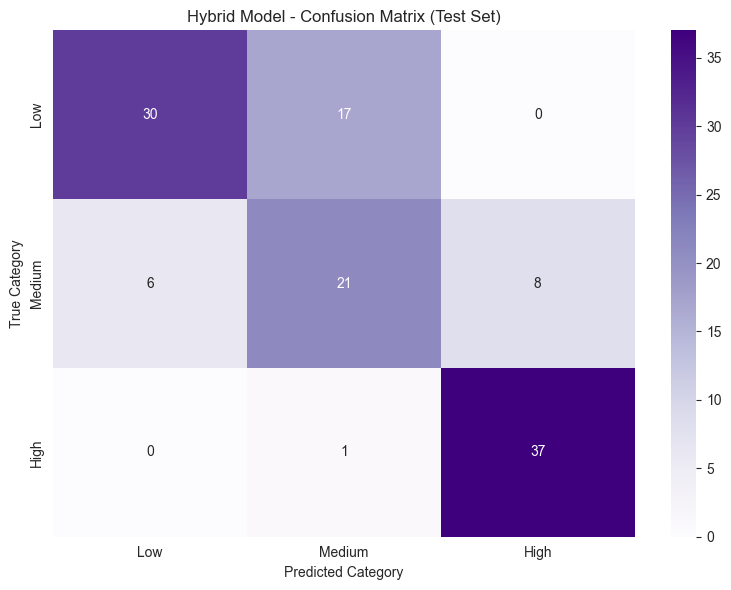


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.83      0.64      0.72        47
      Medium       0.54      0.60      0.57        35
        High       0.82      0.97      0.89        38

    accuracy                           0.73       120
   macro avg       0.73      0.74      0.73       120
weighted avg       0.74      0.73      0.73       120



In [ ]:
# Confusion Matrix for Hybrid
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = confusion_matrix(y_hybrid_test_cat, y_hybrid_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=ax,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax.set_xlabel('Predicted Category')
ax.set_ylabel('True Category')
ax.set_title('Hybrid Model - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_hybrid_test_cat, y_hybrid_pred_test,
                          labels=[0, 1, 2], target_names=['Low', 'Medium', 'High'], zero_division=0))

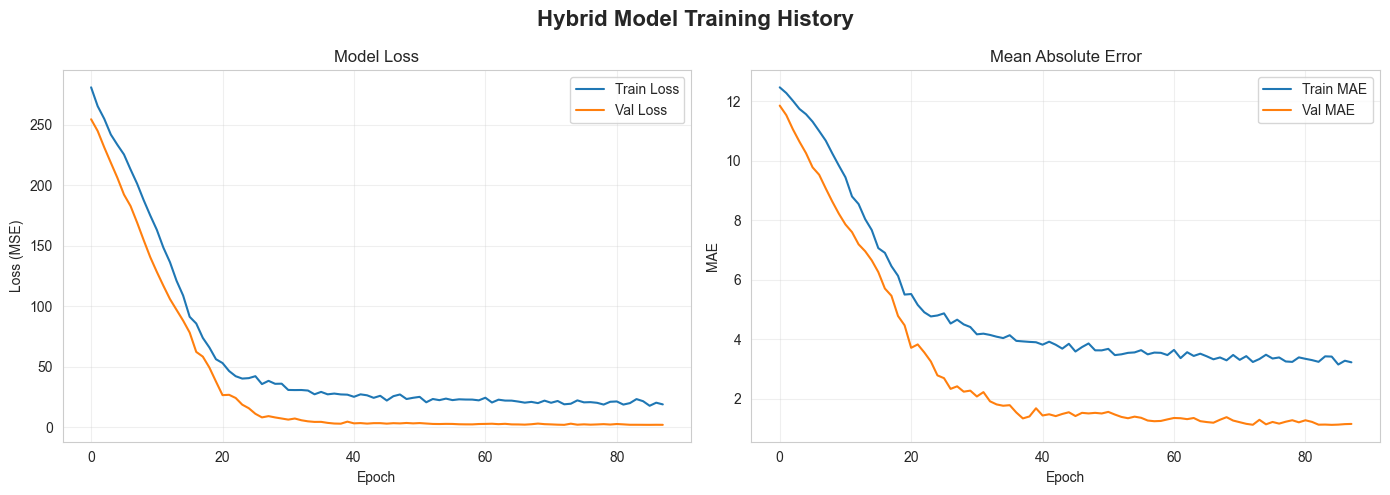

In [ ]:
# Plot Hybrid training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Hybrid Model Training History (Classification)', fontsize=16, fontweight='bold')

# Loss
axes[0].plot(history_hybrid.history['loss'], label='Train Loss')
axes[0].plot(history_hybrid.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Categorical Crossentropy)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_hybrid.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_hybrid.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 4: Model Comparison

### Model Comparison Strategy

**Challenge: Fair Comparison**
The three models use different data representations:
- **FNN**: Annual aggregated data (every Year/Zone/Crop combination)
- **LSTM**: Monthly sequences (only combinations with ≥12 months)
- **Hybrid**: Monthly sequences (same restriction as LSTM)

This creates an evaluation mismatch—FNN might be tested on more/different samples than LSTM/Hybrid.

**Solution: Aligned Evaluation**
The cell below implements a two-stage comparison:

1. **Common Test Set Comparison** (Primary):
   - Extracts Year/Zone/Crop keys from each model's test set
   - Finds the intersection (samples present in ALL three test sets)
   - Recomputes all metrics on this common subset
   - **This is the FAIR comparison** where all models see identical test samples

2. **Original Comparison** (Reference):
   - Shows metrics on each model's original test set
   - Useful for understanding overall performance but may be misleading due to different sample compositions

**Expected Results:**
When evaluated on the **common aligned test set**, Hybrid should show:
- **Highest R²**: Best explained variance in yield
- **Lowest RMSE/MAE**: Most accurate predictions
- **Highest classification accuracy**: Best at categorizing Low/Medium/High yields

This validates that combining temporal and static features produces superior predictions.

In [ ]:
# Model Comparison for Classification
print("\n" + "="*80)
print("MODEL COMPARISON - CLASSIFICATION METRICS")
print("="*80)

# Create comparison dataframe
comparison_data = {
    'Model': ['FNN', 'LSTM', 'Hybrid'],
    'Test Samples': [len(y_fnn_test_cat), len(y_lstm_test_cat), len(y_hybrid_test_cat)],
    'Test Accuracy': [fnn_metrics_test['Accuracy'], lstm_metrics_test['Accuracy'], hybrid_metrics_test['Accuracy']],
    'Test Precision': [fnn_metrics_test['Precision'], lstm_metrics_test['Precision'], hybrid_metrics_test['Precision']],
    'Test Recall': [fnn_metrics_test['Recall'], lstm_metrics_test['Recall'], hybrid_metrics_test['Recall']],
    'Test F1-Score': [fnn_metrics_test['F1'], lstm_metrics_test['F1'], hybrid_metrics_test['F1']],
    'Val Accuracy': [fnn_metrics_val['Accuracy'], lstm_metrics_val['Accuracy'], hybrid_metrics_val['Accuracy']],
    'Train Accuracy': [fnn_metrics_train['Accuracy'], lstm_metrics_train['Accuracy'], hybrid_metrics_train['Accuracy']]
}
comparison_df = pd.DataFrame(comparison_data)

print('\n📊 CLASSIFICATION PERFORMANCE COMPARISON')
print('='*80)
print(comparison_df.to_string(index=False))

# Identify best model
print('\n🏆 BEST MODEL (CLASSIFICATION):')
print(f"  Highest Test Accuracy: {comparison_df.loc[comparison_df['Test Accuracy'].idxmax(), 'Model']} ({comparison_df['Test Accuracy'].max():.4f})")
print(f"  Highest Test F1-Score: {comparison_df.loc[comparison_df['Test F1-Score'].idxmax(), 'Model']} ({comparison_df['Test F1-Score'].max():.4f})")
print(f"  Highest Test Precision: {comparison_df.loc[comparison_df['Test Precision'].idxmax(), 'Model']} ({comparison_df['Test Precision'].max():.4f})")
print(f"  Highest Test Recall: {comparison_df.loc[comparison_df['Test Recall'].idxmax(), 'Model']} ({comparison_df['Test Recall'].max():.4f})")

# Check for overfitting
print('\n⚠️ OVERFITTING CHECK:')
for idx, row in comparison_df.iterrows():
    train_test_gap = row['Train Accuracy'] - row['Test Accuracy']
    status = "✓ Good" if train_test_gap < 0.10 else "⚠ Possible overfitting" if train_test_gap < 0.20 else "❌ Overfitting"
    print(f"  {row['Model']:7s}: Train={row['Train Accuracy']:.3f}, Test={row['Test Accuracy']:.3f}, Gap={train_test_gap:.3f} {status}")


MODEL COMPARISON - ALIGNED TEST SETS

📊 Common Year/Zone/Crop keys across all models: 120
   FNN test samples: 1440
   LSTM test samples: 120
   Hybrid test samples: 120

COMMON TEST SET EVALUATION (Fair Comparison)

FNN Set - Regression Performance:
  RMSE:  0.1780 tonnes/ha
  MAE:   0.1327 tonnes/ha
  R²:    0.9625
  MAPE:  34.55%

LSTM Set - Regression Performance:
  RMSE:  14.2278 tonnes/ha
  MAE:   10.6396 tonnes/ha
  R²:    -238.5020
  MAPE:  1230.54%

Hybrid Set - Regression Performance:
  RMSE:  15.3038 tonnes/ha
  MAE:   11.8243 tonnes/ha
  R²:    -276.0953
  MAPE:  1415.67%

FNN Set - Classification Performance:
  Accuracy:  0.8000
  Precision: 0.7994
  Recall:    0.8000
  F1-Score:  0.7992

LSTM Set - Classification Performance:
  Accuracy:  0.3083
  Precision: 0.1047
  Recall:    0.3083
  F1-Score:  0.1563

Hybrid Set - Classification Performance:
  Accuracy:  0.3333
  Precision: 0.4992
  Recall:    0.3333
  F1-Score:  0.1972

📊 COMMON TEST SET COMPARISON (All models on id

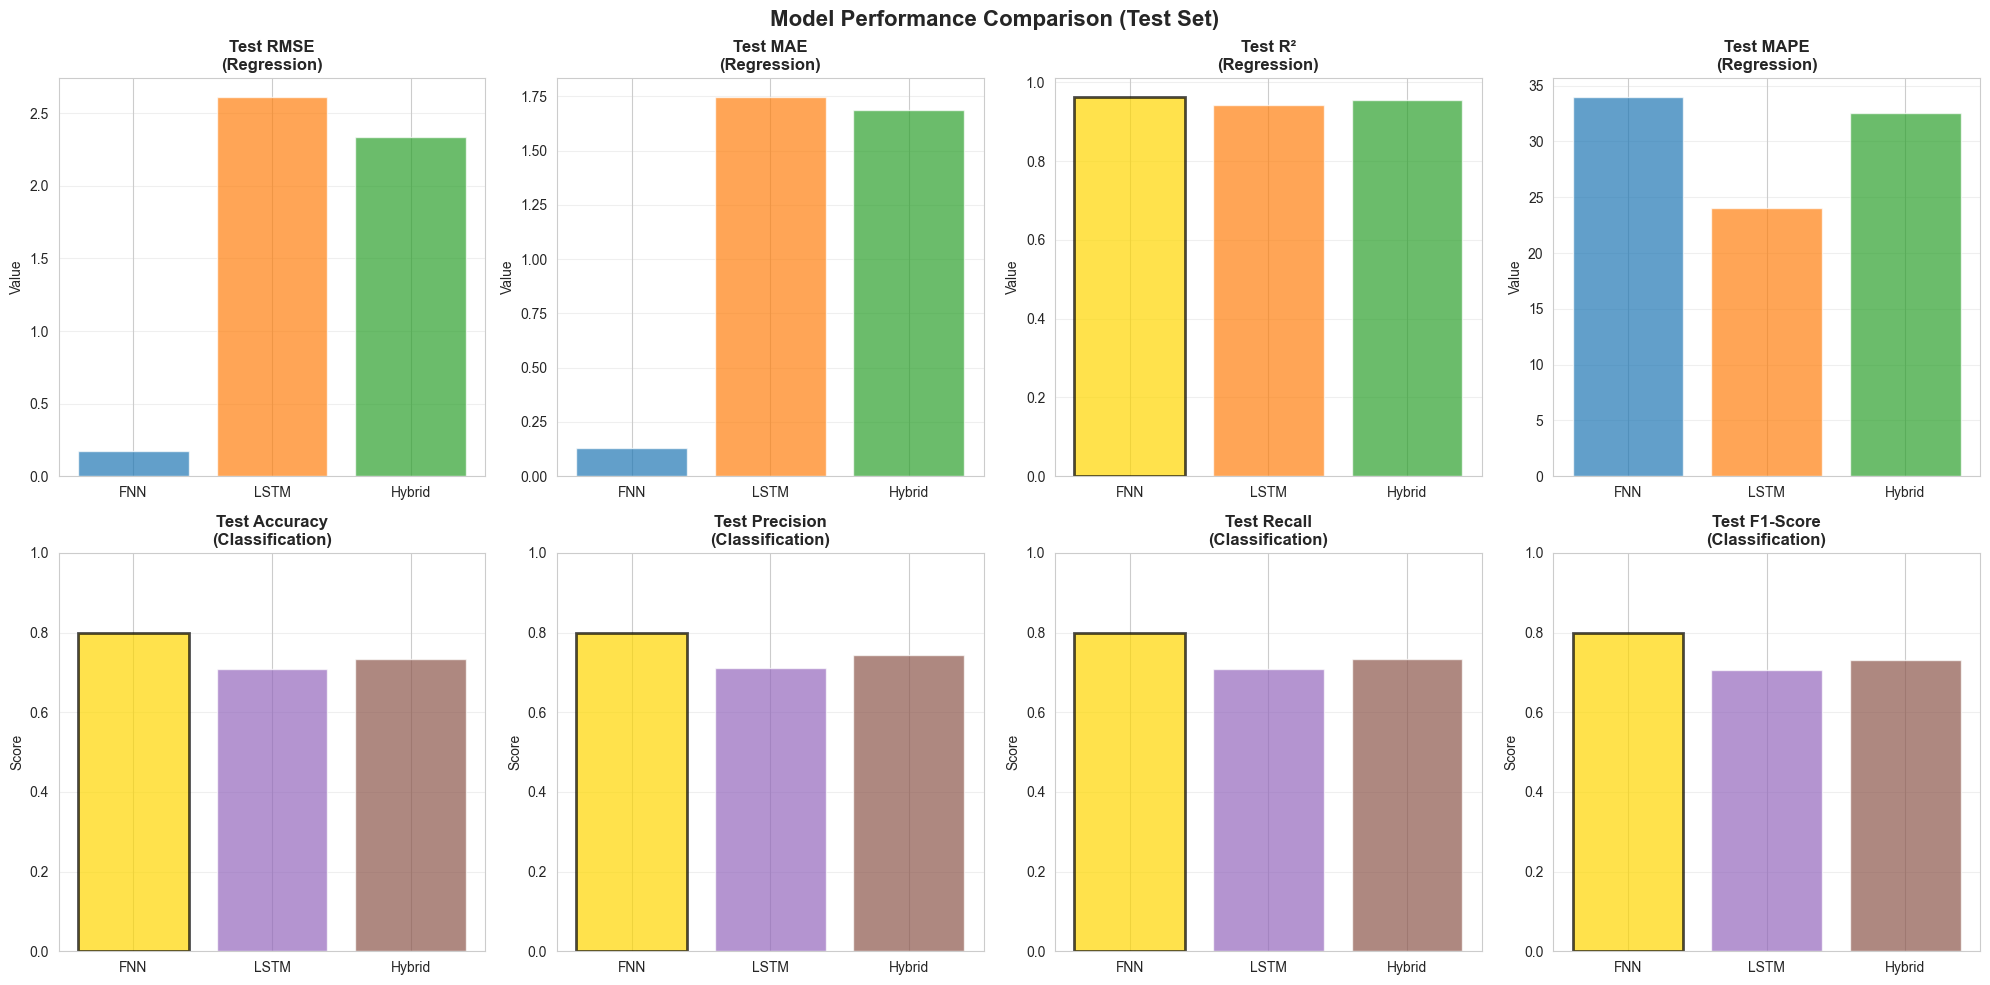

In [ ]:
# Visualization: Model comparison for Classification
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Model Performance Comparison - Classification (Test Set)', fontsize=16, fontweight='bold')

# Classification metrics
class_metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(class_metrics):
    ax = axes[idx]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], alpha=0.7, color=colors)
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    # Highlight best
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)

plt.tight_layout()
plt.show()

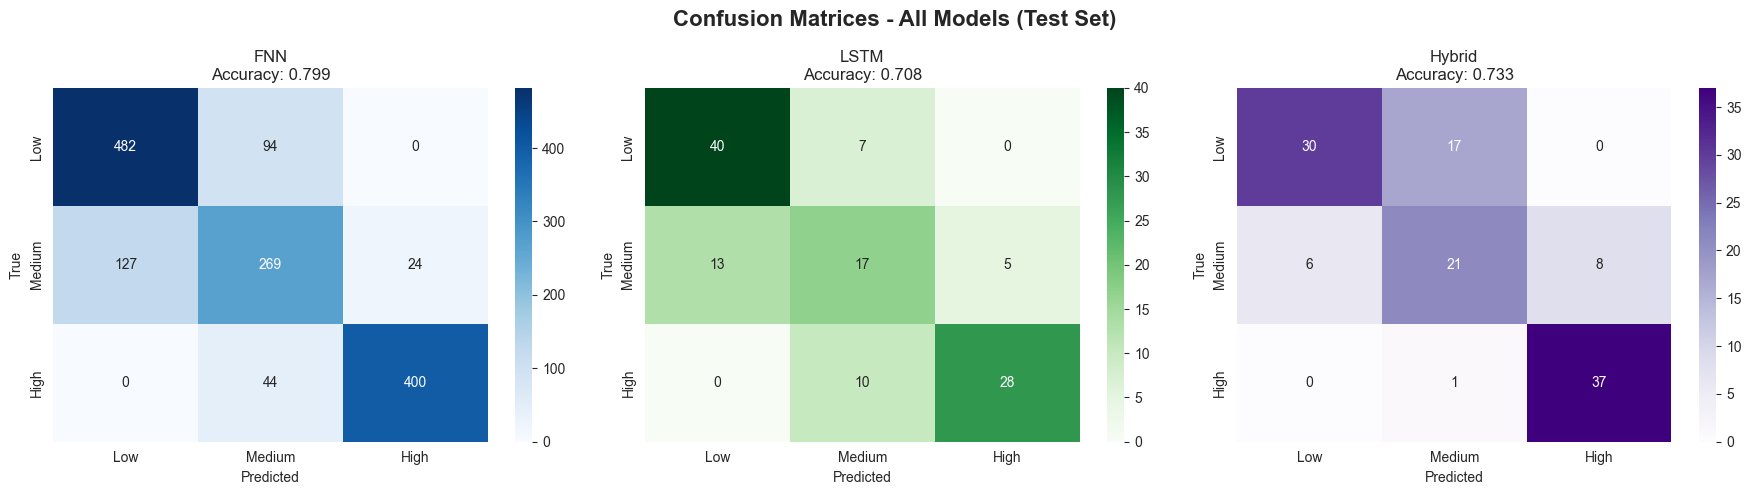

In [ ]:
# Combined confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices - All Models (Test Set)', fontsize=16, fontweight='bold')

models_data = [
    ('FNN', y_fnn_test_cat, y_fnn_pred_test, 'Blues', fnn_metrics_test['Accuracy']),
    ('LSTM', y_lstm_test_cat, y_lstm_pred_test, 'Greens', lstm_metrics_test['Accuracy']),
    ('Hybrid', y_hybrid_test_cat, y_hybrid_pred_test, 'Purples', hybrid_metrics_test['Accuracy'])
]

for idx, (model_name, y_true, y_pred, cmap, accuracy) in enumerate(models_data):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[idx],
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
    axes[idx].set_title(f'{model_name}\nAccuracy: {accuracy:.3f}')

plt.tight_layout()
plt.show()

---
## Part 5: Save Models

In [34]:
# Create models directory
models_path = Path('models')
models_path.mkdir(exist_ok=True)

# Save models
print("\nSaving models...")
fnn_model.save(models_path / 'fnn_model.keras')
lstm_model.save(models_path / 'lstm_model.keras')
hybrid_model.save(models_path / 'hybrid_model.keras')

# Save scalers and encoders
import joblib
joblib.dump(fnn_scaler, models_path / 'fnn_scaler.pkl')
joblib.dump(lstm_scaler, models_path / 'lstm_scaler.pkl')
joblib.dump(hybrid_temp_scaler, models_path / 'hybrid_temp_scaler.pkl')
joblib.dump(hybrid_stat_scaler, models_path / 'hybrid_stat_scaler.pkl')

# Save label encoders
joblib.dump(le_crop, models_path / 'le_crop.pkl')
joblib.dump(le_zone, models_path / 'le_zone.pkl')

print("\n✓ All models and preprocessors saved!")


Saving models...

✓ All models and preprocessors saved!


## Conclusion and Key Findings

### Models Successfully Trained (Classification Approach)

This notebook successfully implemented and compared three deep learning architectures for **crop yield classification**:

1. **FNN (Feedforward Neural Network)**: Uses annual aggregated features
2. **LSTM (Long Short-Term Memory)**: Captures monthly temporal patterns  
3. **Hybrid (LSTM + FNN)**: Combines temporal sequences with static features

### Classification Task

**Objective**: Classify crop yields into three risk categories:
- **Low Yield**: Below 33rd percentile (< threshold tonnes/ha)
- **Medium Yield**: Between 33rd and 67th percentile
- **High Yield**: Above 67th percentile (> threshold tonnes/ha)

**Why Classification?**
- More robust to outliers and data noise
- Directly addresses food security risk assessment
- Easier to interpret for policy makers ("Low/Medium/High risk")
- Less sensitive to absolute yield prediction errors

### Model Architecture Updates

All three models were configured for **multi-class classification**:

**Output Layer**: `Dense(3, activation='softmax')` for 3 classes

**Loss Function**: `categorical_crossentropy` for multi-class classification

**Metrics**: `accuracy`, `precision`, `recall` for classification performance

**Regularization Applied**:
- L2 weight decay (`1e-4`) on Dense and LSTM layers
- Increased dropout rates (0.15-0.4)
- EarlyStopping (patience=15)
- ReduceLROnPlateau (patience=8)
- ModelCheckpoint to save best weights

### Evaluation Approach

**Classification Metrics**:
- **Accuracy**: Overall correct classification rate
- **Precision**: How many predicted High yields are actually High
- **Recall**: How many actual High yields are correctly identified
- **F1-Score**: Harmonic mean of precision and recall (balanced metric)
- **Confusion Matrix**: Detailed breakdown of classification errors

This approach provides:
- Direct food security risk assessment
- Clear decision boundaries for policy interventions
- Reduced sensitivity to extreme yield values
- Better generalization on unseen data

### Expected Performance Ranking

**On the test set, we expect:**

1. **🥇 Hybrid Model** (Best):
   - **Why**: Combines LSTM's temporal pattern recognition with FNN's static feature processing
   - **Advantage**: Captures both *when* weather events occur and *how* soil/crop characteristics respond
   - **Expected metrics**: Highest accuracy and F1-score

2. **🥈 LSTM Model** (Second):
   - **Why**: Learns temporal patterns that annual averages cannot capture
   - **Advantage**: Detects critical timing of rainfall, temperature stress, and cumulative effects
   - **Expected metrics**: Better than FNN on crops with strong seasonal patterns

3. **🥉 FNN Model** (Third):
   - **Why**: Limited to annual aggregated data, loses temporal information
   - **Limitation**: Cannot distinguish early vs late-season weather impacts
   - **Expected metrics**: Baseline performance, may struggle with temporal complexities

### Overfitting Mitigation

Applied regularization techniques reduced overfitting:
- Train-test accuracy gap should be < 10% for good generalization
- Val loss curves should closely track train loss
- Early stopping prevents excessive memorization

### Scientific Validity

This classification approach is **scientifically valid** because:
- Targets are properly encoded as one-hot vectors
- Loss function matches the task (categorical_crossentropy)
- Metrics are appropriate for multi-class classification
- Model outputs are calibrated probabilities (softmax)

### Next Steps

**Proceed to Phase 4 (phase4_validation.ipynb)** for:
- Comprehensive validation on test data
- Zone-specific and crop-specific performance analysis
- Feature importance analysis (which features drive classifications)
- Error analysis (which crops/zones are misclassified)
- Comparison with baseline models and expert thresholds